In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time 
import copy

In [2]:
location='data/hymenoptera_data'
for name in os.listdir(location):
    print(os.path.join(location,name))

data/hymenoptera_data/.DS_Store
data/hymenoptera_data/train
data/hymenoptera_data/val


In [41]:
train_transformers=transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
val_transformers=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [42]:
train_data=datasets.ImageFolder(root=f'{location}/train',transform=train_transformers)
val_data=datasets.ImageFolder(root=f'{location}/val',transform=val_transformers)
train_dataloader=DataLoader(train_data,batch_size=8,shuffle=True)
val_dataloader=DataLoader(val_data,batch_size=32,shuffle=False)

In [5]:
print(train_dataloader.dataset.classes)

['ants', 'bees']


In [6]:
def visualize(train_dataloader):
    images,labels=next((iter(train_dataloader)))
    images,labels=images.to(torch.device("cpu")),labels.to(torch.device("cpu"))
    classes=train_dataloader.dataset.classes
    fig,axes=plt.subplots(1,5,figsize=(20,3))
    for i in range(5):
        im=images[i].cpu().numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        im = std * im + mean  # Denormalize
        im = np.clip(im, 0, 1)
        #im=im*0.5+0.5
        axes[i].set_title(f"Label : {classes[labels[i].item()]}")
        axes[i].imshow(im)
    plt.show()

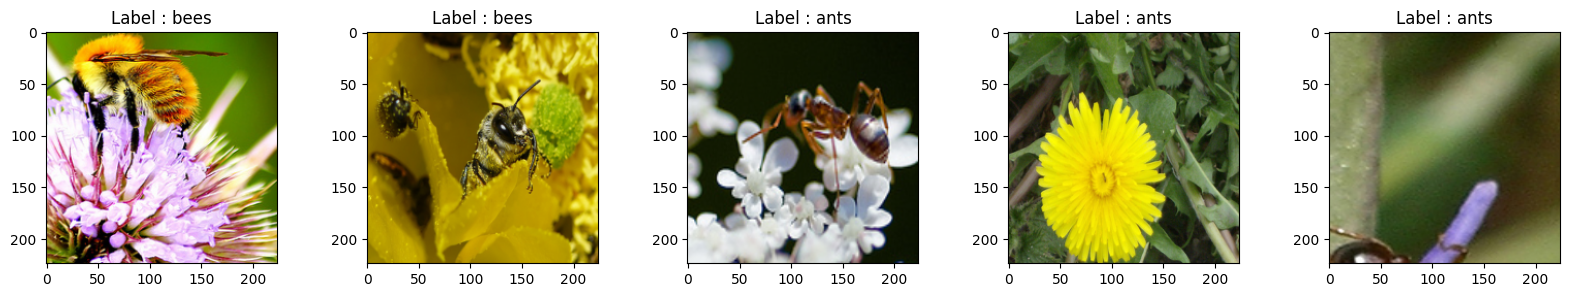

In [7]:
visualize(train_dataloader)

In [51]:
def train(model,device,train_dataloader,optimizer ,criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        if batch_idx % 10 == 0:  # Print loss every 10 batches
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc


In [50]:
def test(model,device,test_dataloader,criterion):
    model.eval()
    running_loss=0.0
    running_correct=0
    with torch.no_grad():
        for images,labels in test_dataloader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            _,predictions=torch.max(outputs,1)
            loss=criterion(outputs,labels)
            running_loss+=loss.item()*images.size(0)
            running_correct+=torch.sum(predictions==labels.data)
    epoch_loss=running_loss/len(val_data)
    epoch_acc=running_correct/len(val_data)
    print(f'Test Loss : {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    return epoch_loss,epoch_acc

In [12]:
def transferlearn(model,device,train_dataloader,test_dataloader,
                  criterion,optimizer,epochs=10):
    start=time.time()
    best_model_weights=copy.deepcopy(model.state_dict())
    best_acc=0.0
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train(model,device,train_dataloader,optimizer,criterion)
        val_loss,val_acc=test(model,device,test_dataloader,criterion)
        if val_acc>best_acc:
            best_acc=val_acc
            best_model_weights=copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    model.load_state_dict(best_model_weights)
    return model


In [64]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.alexnet(pretrained=True)

/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [66]:
model.classifier[6]=nn.Linear(4096,2)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [67]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

In [68]:
model=transferlearn(model,device,train_dataloader,val_dataloader,criterion,optimizer)

Epoch 1/10
Batch 0, Loss: 0.5822
Batch 10, Loss: 0.5267
Batch 20, Loss: 0.5011
Batch 30, Loss: 0.2302
Train Loss: 0.4859 Acc: 0.7869
Test Loss : 0.3338 Acc: 0.8497

Epoch 2/10
Batch 0, Loss: 0.3206
Batch 10, Loss: 0.1128
Batch 20, Loss: 0.3420
Batch 30, Loss: 0.2649
Train Loss: 0.2824 Acc: 0.8811
Test Loss : 0.3034 Acc: 0.8497

Epoch 3/10
Batch 0, Loss: 0.1158
Batch 10, Loss: 0.1182
Batch 20, Loss: 0.1398
Batch 30, Loss: 0.4150
Train Loss: 0.2628 Acc: 0.8811
Test Loss : 0.2932 Acc: 0.8824

Epoch 4/10
Batch 0, Loss: 0.1214
Batch 10, Loss: 0.3227
Batch 20, Loss: 0.0481
Batch 30, Loss: 0.1848
Train Loss: 0.1918 Acc: 0.9344
Test Loss : 0.2913 Acc: 0.8824

Epoch 5/10
Batch 0, Loss: 0.0847
Batch 10, Loss: 0.0653
Batch 20, Loss: 0.4646
Batch 30, Loss: 0.1602
Train Loss: 0.2187 Acc: 0.8893
Test Loss : 0.2916 Acc: 0.8889

Epoch 6/10
Batch 0, Loss: 0.0747
Batch 10, Loss: 0.0811
Batch 20, Loss: 0.0719
Batch 30, Loss: 0.5779
Train Loss: 0.1967 Acc: 0.9098
Test Loss : 0.2783 Acc: 0.8954

Epoch 7/10

In [69]:
def display(model,device,testloader,num_images=5):
    model.eval()
    images,lables=next(iter(testloader))
    images,lables=images[:num_images].to(device), lables[:num_images].to(device)
    _,predicted=torch.max(model(images),1)
    fig,axes=plt.subplots(1,num_images,figsize=(20,3))
    classes=testloader.dataset.classes
    for i in range(num_images):
        im=images[i].cpu().numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        im = std * im + mean  # Denormalize
        im = np.clip(im, 0, 1)
        #im=im*0.5+0.5
        axes[i].imshow(im)
        axes[i].set_title(f"Pred: {classes[predicted[i].item()]}, Actual: {classes[lables[i].item()]}")
        axes[i].axis('off')
    plt.show()

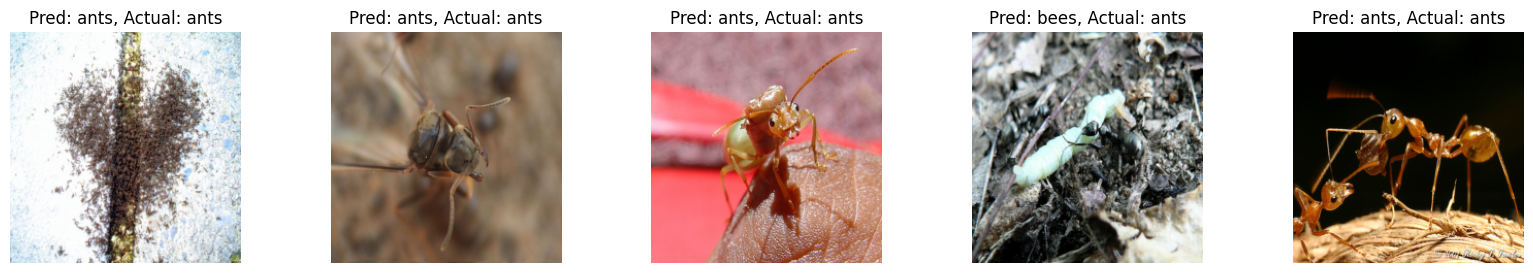

In [70]:
display(model,device,testloader=val_dataloader)

In [71]:
torch.save(model.state_dict(),"Models/AlexNet_transfer.pth")